# Mapping Accessibility to Los Angeles Libraries
## Week 07 Homework Assignment
### Sophie Frank, Adam Lipsey, Maya Deshpande, Elizabeth Greenfield

First import all necessary libraries and read in the Social Vulnerability Index data.

In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
svi_data = pd.read_csv('cdc-svi-data.csv')

Turn dataset columns into a list, drop columns with only NaN values.

In [193]:
svi_data.columns[svi_data.isna().all()].tolist()
svi_data = svi_data.dropna(axis=1,how="all")

Keep the relevant columns in a list.

In [194]:
columns_to_keep = ['FIPS',
                   'RPL_THEME1',
                   'RPL_THEME2',
                   'RPL_THEME3',
                   'RPL_THEME4',
                   'RPL_THEMES'
                  ]

Turn the relevant columns into a dataset.

In [195]:
svi_data_final = svi_data[columns_to_keep]

Create a list of new column names and assign them to the dataset we just created.

In [196]:
columns = list(svi_data_final) # this is the same as df.columns.to_list()
svi_data_final.columns = ['FIPS',
'socio_econ_v_score',
'household_char_v_score',
'racial_ethnic_v_score',
'housing_transportation_v_score',
'final_v_score']

Now read in a geojson file downloaded from the LA Times containing tract ID's.

In [197]:
tracts = gpd.read_file('census_tracts_2010.geojson')

Keep and rename only the ID and geometry columns from the tracts dataset.

In [198]:
tracts = tracts[['GEOID10','geometry']]
tracts.rename(columns = {'GEOID10':'FIPS'}, inplace = True)

Set FIPS column values as type INT to avoid errors. Merge the two datasets.

In [199]:
svi_data_final['FIPS'] = svi_data_final['FIPS'].astype(int)
tracts['FIPS'] = tracts['FIPS'].astype(int)

tracts_svi = tracts.merge(svi_data_final,on="FIPS")

/tmp/ipykernel_81/527461499.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svi_data_final['FIPS'] = svi_data_final['FIPS'].astype(int)


Get rid of tracts that did not get assigned a final SVI score (tracts that have a score of -999.00).

In [200]:
index_final_score = tracts_svi[(tracts_svi['final_v_score'] == -999.00)].index
tracts_svi.drop(index_final_score, inplace=True)

Double check that there are no tracts without SVI scores in the dataset.

In [201]:
tracts_without_final_score = tracts_svi.loc[(tracts_svi['final_v_score'] == -999.00)]
tracts_without_final_score.head()

,FIPS,geometry,socio_econ_v_score,household_char_v_score,racial_ethnic_v_score,housing_transportation_v_score,final_v_score


Map the vulnerability scores for census tracts.

Vulnerability Scores Based Only on Household Characteristics in LA Census Tracts


<AxesSubplot: >

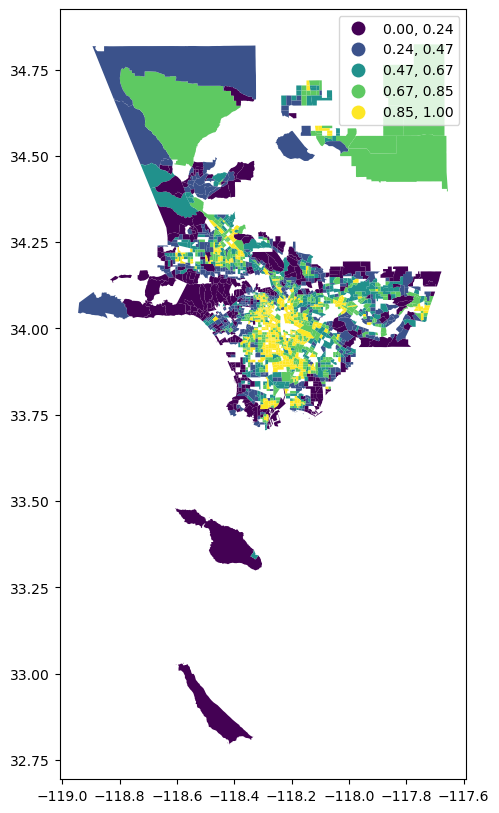

In [202]:
print("Vulnerability Scores Based Only on Household Characteristics in LA Census Tracts")
tracts_svi.plot(figsize=(12,10),
                 column='final_v_score',
                 legend=True, 
                 scheme='NaturalBreaks')

In [203]:
libraries = pd.read_csv('Libraries - City_County.csv')

In [204]:
desired_columns = ['org_name','Name','city', 'zip', 'latitude', 'longitude']

In [205]:
libraries_trimmed = libraries[desired_columns].copy()

In [206]:
pd.set_option('display.max_rows', None)

In [207]:
countylib = libraries_trimmed.loc[libraries_trimmed['org_name'] == 'LA County']

In [208]:
geocountylib = gpd.GeoDataFrame(countylib, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(countylib.longitude, countylib.latitude))

In [209]:
lapl = libraries_trimmed.loc[libraries_trimmed['org_name'] == 'City of LA']

In [210]:
geolapl = gpd.GeoDataFrame(lapl, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(lapl.longitude, lapl.latitude))

In [217]:
city_gdf = gpd.read_file('City_Boundaries.csv')

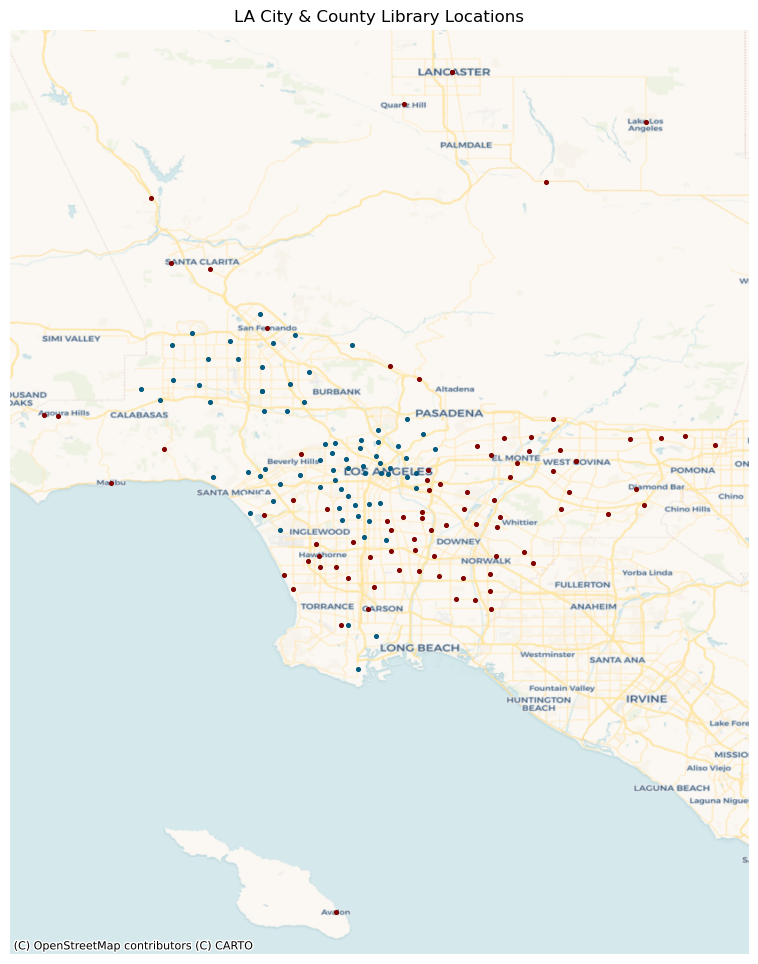

In [218]:
fig, ax = plt.subplots(figsize=(12,12))

geolapl.plot(ax=ax, 
        marker='o',
        markersize=7,
        color='#005a80',
        label='City of LA Public Library')

geocountylib.plot(ax=ax, 
        marker='o',
        markersize=7,
        color='#800000',
        label='LA County Public Library')

city_gdf.plot(ax=ax,
        facecolor='none',
        edgecolor='black',
        linewidth=0.5)

#legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

ax.axis('off')

ax.set_title('LA City & County Library Locations')
#ax.set_title('LA City Library Locations')

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs=4326)

In [219]:
#In order to show the proximity of libraries to areas that have a lower Social Vulnerability Index, I overlayed the two maps.


In [220]:
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

Text(0.5, 1.0, 'Library Locations over SVI tracts')

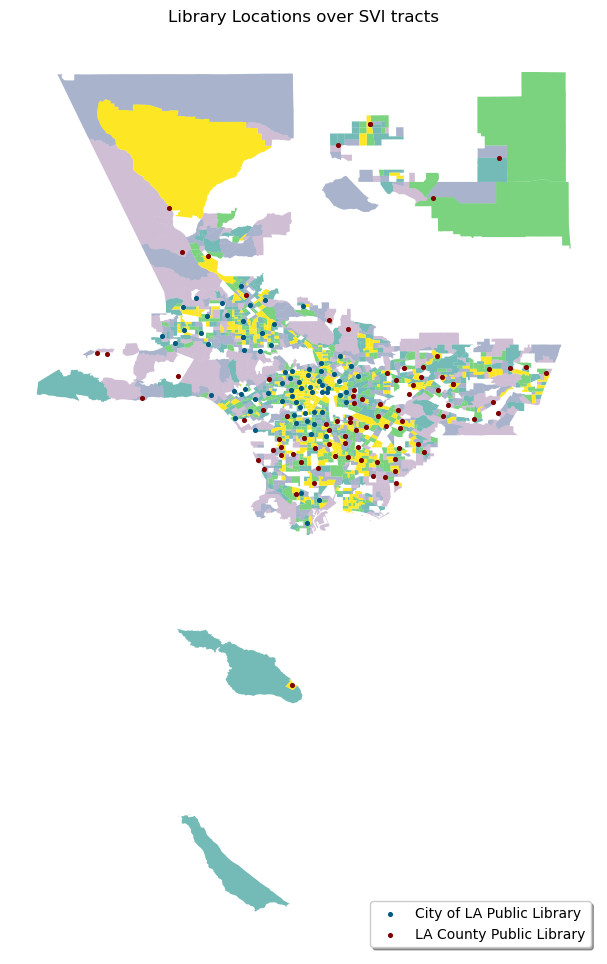

In [221]:
# Create a desaturated version of the viridis colormap
viridis_desat = cm.get_cmap('viridis', 256)
viridis_desat = viridis_desat(np.linspace(0, 1, 256))
viridis_desat[:, -1] = np.linspace(0.25, 1, 256) # adjust the alpha channel for desaturation
viridis_desat = ListedColormap(viridis_desat)

fig, ax = plt.subplots(figsize=(12,12))

tracts_svi.plot(ax = ax,
                figsize=(12,10),
                column='housing_transportation_v_score',
                legend=True, 
                scheme='NaturalBreaks',
                cmap=viridis_desat) # set the colormap to the desaturated version of viridis

geolapl.plot(ax = ax, 
        marker='o',
        markersize=7,
        color='#005a80',
        label='City of LA Public Library')

geocountylib.plot(ax = ax, 
        marker='o',
        markersize=7,
        color='#800000',
        label='LA County Public Library')

city_gdf.plot(ax = ax,
        facecolor='none',
        edgecolor='black',
        linewidth=0.5)

legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')
ax.axis('off')
ax.set_title('Library Locations over SVI tracts')